# High-Precision Wave Hydrodynamics & Structural Impact Solver
**Method:** Fenton's Fourier Approximation (Stream Function Theory)  
**Type:** Nonlinear BVP Solver & Transient Load Calculator

In [1]:
# ==============================================================================
#  SECTION 1: PHYSICAL CONSTANTS & CONFIGURATION
# ==============================================================================

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages  # <--- ADDED THIS IMPORT
from scipy.optimize import least_squares, minimize_scalar
import sys
import os

# -- Configure Plotting for Notebook --
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.5, 11.7) # Match A3 size from script.py
plt.rcParams['figure.dpi'] = 100              # Decent preview resolution

# -- Simulation Parameters --
DEF_WAVE_HEIGHT    = 3.0000      # H (m)
DEF_WAVE_PERIOD    = 9.0000      # T (s)
DEF_DEPTH          = 5.0000      # d (m)
DEF_CURRENT        = 1.0000      # Uc (m/s)
DEF_CURRENT_TYPE   = "Eulerian"  # 'Eulerian' or 'Stokes'
DEF_PILE_DIAMETER  = 1.5000      # D (m)
DEF_MARINE_GROWTH  = 0.0500      # t_mg (m)
DEF_SOLVER_ORDER   = 50          # N
DEF_HOMOTOPY_STEPS = 5           # Steps
DEF_PLOT_CYCLES    = 2.0         # Cycles to plot
DEF_SAVE_PNGS      = True        # <--- ADDED CONFIG

# -- Physical Constants --
RHO          = np.float64(1025.0)
G_STD        = np.float64(9.8066)
NU_SEAWATER  = np.float64(1.05e-6)
DTYPE        = np.float64

# -- Utilities --
def print_row(description, value, unit=""):
    if isinstance(value, (float, int, np.floating, np.integer)):
        val_str = f"{value:<15.4f}" 
    else:
        val_str = f"{str(value):<15}" 
    print(f"{description:<41}| {val_str} | {unit}")

def add_param_box(ax, wave, extra_text=""):
    ursell = (wave.H_target * wave.L**2) / (wave.d**3)
    steepness = wave.H_target / wave.L
    
    text_str = (
        f"INPUTS:\n"
        f"H = {wave.H_target:.2f} m\n"
        f"T = {wave.T_target:.2f} s\n"
        f"d = {wave.d:.2f} m\n"
        f"Uc ({wave.current_type}) = {wave.Uc:.2f} m/s\n"
        f"Order = {wave.N}\n\n"
        f"PARAMS:\n"
        f"L = {wave.L:.2f} m\n"
        f"Ur = {ursell:.1f}\n"
        f"H/L = {steepness:.4f}"
    )
    if extra_text:
        text_str += f"\n\nOUTPUTS:\n{extra_text}"
        
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, zorder=10)

In [2]:
# ==============================================================================
#  SECTION 2: CORE SOLVER LOGIC (FENTON STREAM FUNCTION)
# ==============================================================================

class FentonWave:
    """
    PRIMARY HYDRODYNAMIC SOLVER:
    Implements the Fourier Approximation Method for the Nonlinear Stream Function.
    """
    def __init__(self, H, T, d, current, current_type='Eulerian', N_target=DEF_SOLVER_ORDER, n_steps=DEF_HOMOTOPY_STEPS):
        # -- 1. Store Inputs --
        self.H_target = float(H)    
        self.T_target = float(T)    
        self.d = float(d)           
        
        if self.d <= 0: raise ValueError("Water depth (d) must be positive.")
        if self.T_target <= 0: raise ValueError("Wave period (T) must be positive.")
        
        # -- CRITICAL LIMIT CHECK: H/d <= 0.6 --
        if (self.H_target / self.d) > 0.6:
             print(f"\n[!] LIMIT EXCEEDED: H/d = {self.H_target/self.d:.3f} > 0.6. Calculation aborted.")
             self.converged = False
             self.solver_history = [{
                "H": self.H_target, "Err": 0.0, 
                "Msg": "H/d > 0.6 Limit", "Status": "ABORT", "Type": "Limit"
             }]
             self.k = 0.0
             return

        if self.H_target >= self.d: print("WARNING: Wave height exceeds water depth.")

        self.Uc = float(current)    
        self.current_type = current_type 
        self.g = float(G_STD)
        self.N = int(N_target)      
        self.n_steps = int(n_steps) 
        
        # -- 2. Solver Diagnostics --
        self.solver_history = []    
        self.converged = False      
        
        # -- 3. State Vectors --
        self.Bj = np.zeros(self.N, dtype=DTYPE)
        self.Ej = np.zeros(self.N, dtype=DTYPE)
        self.eta_nodes = np.zeros(self.N+1, dtype=DTYPE) 
        
        # -- 4. Physical Properties Container --
        self.prop_KE = 0.0; self.prop_PE = 0.0   
        self.prop_I = 0.0; self.prop_Sxx = 0.0   
        self.prop_F = 0.0; self.prop_ub2 = 0.0   
        self.prop_q_vol = 0.0; self.prop_S = 0.0 
        self.prop_R = 0.0; self.prop_r = 0.0     
        self.prop_u1 = 0.0; self.prop_u2 = 0.0   
        self.prop_U_frame = 0.0                  
        
        # -- 5. Wave Parameters --
        self.k = 0.0 
        self.L = 0.0 
        self.c = 0.0 
        self.Q = 0.0 
        self.R = 0.0 
        
        # -- 6. Execution --
        try:
            self._solve_adaptive()                
            self._calculate_integral_properties() 
        except Exception as e:
            self.converged = False
            self.solver_history.append({
                "H": self.H_target, "Err": 999.9, 
                "Msg": f"Exception: {e}", "Status": "ERR", "Type": "Fail"
            })

    def _pack_state(self, k, eta, B, Q, R):
        return np.concatenate(([k], eta, B, [Q, R])).astype(DTYPE)

    def _unpack_state(self, x):
        M = self.N
        k = x[0]                    
        etas = x[1 : M+2]           
        Bs = x[M+2 : 2*M+2]         
        Q = x[-2]                   
        R = x[-1]                   
        return k, etas, Bs, Q, R

    def _basis_functions(self, k, eta_or_z_nodes):
        kd = k * self.d
        z_vals = np.atleast_1d(eta_or_z_nodes).astype(DTYPE)
        S = np.zeros((self.N, len(z_vals)), dtype=DTYPE)
        C = np.zeros((self.N, len(z_vals)), dtype=DTYPE)
        
        for j in range(1, self.N + 1):
            idx = j - 1
            arg_check = j * kd
            
            if arg_check > 20.0:
                exp_term = np.exp(j * k * (z_vals - self.d))
                S[idx, :] = exp_term; C[idx, :] = exp_term
            else:
                arg = j * k * z_vals
                denom = np.cosh(j * kd)
                S[idx, :] = np.sinh(arg) / denom 
                C[idx, :] = np.cosh(arg) / denom

        return S, C

    def _residuals(self, x, H_curr):
        k, etas, Bs, Q, R = self._unpack_state(x)
        if k <= 1e-8: k = 1e-8 
        c = (2*np.pi)/(k*self.T_target) 
        
        if self.current_type == 'Eulerian':
            U_frame = c - self.Uc
        else:
            U_frame = Q / self.d 
            
        S_mat, C_mat = self._basis_functions(k, etas)
        x_nds = np.linspace(0, np.pi/k, self.N+1)
        phases = k * x_nds
        js = np.arange(1, self.N+1)
        
        cos_t = np.cos(np.outer(js, phases))
        sc = np.sqrt(self.g / k**3) 
        
        psi_pert = np.sum(Bs[:,None]*S_mat*cos_t, axis=0) * sc
        u_pert   = np.sum(Bs[:,None]*(js[:,None]*k)*C_mat*cos_t, axis=0) * sc
        v_pert   = np.sum(Bs[:,None]*(js[:,None]*k)*S_mat*(-np.sin(np.outer(js, phases))), axis=0) * sc
        
        res_kin = (-U_frame*etas + psi_pert + Q) / (np.sqrt(self.g*self.d)*self.d)
        
        u_tot = U_frame - u_pert 
        bern = 0.5*(u_tot**2 + v_pert**2) + self.g*etas
        res_dyn = (bern - R) / (self.g*self.d)
        
        res_h = (etas[0] - etas[-1] - H_curr)/self.d
        mean_eta = (np.sum(etas) - 0.5*etas[0] - 0.5*etas[-1])/self.N
        res_lvl = (mean_eta - self.d)/self.d
        
        res_cur = 0.0
        if self.current_type != 'Eulerian':
             res_cur = ((c - Q/self.d) - self.Uc) / np.sqrt(self.g*self.d)
             
        return np.concatenate(([res_cur, res_h, res_lvl], res_kin, res_dyn))

    def _solve_adaptive(self):
        """
        Homotopy Solver Strategy.
        Uses standard linear stepping since H/d is restricted to <= 0.6.
        """
        # A. Initialization: Linear Wave Theory (Airy)
        L0 = (self.g * self.T_target**2) / (2 * np.pi)
        
        if (self.d / L0) < 0.05:
            k0 = 2*np.pi / (self.T_target * np.sqrt(self.g * self.d))
        else:
            k0 = 2*np.pi / L0

        u_doppler = self.Uc if self.current_type == 'Eulerian' else 0.0
        
        for _ in range(20):
            sig = 2*np.pi/self.T_target - k0*u_doppler
            k0 = 0.5*k0 + 0.5*(sig**2/(self.g*np.tanh(k0*self.d)))
            
        x_nds = np.linspace(0, np.pi/k0, self.N+1)
        eta_i = self.d + (0.01/2)*np.cos(k0*x_nds)
        B_i = np.zeros(self.N); Q_i = (2*np.pi/k0/self.T_target - self.Uc)*self.d
        R_i = 0.5*(Q_i/self.d)**2 + self.g*self.d
        
        x_curr = self._pack_state(k0, eta_i, B_i, Q_i, R_i)
        
        # B. Stepping Configuration - Simple Linear Steps
        default_steps = globals().get('DEF_HOMOTOPY_STEPS', 5)
        user_steps = getattr(self, 'n_steps', default_steps)
        n_steps = max(3, user_steps)
        
        h_start_log = 0.01
        
        # Simple linear distribution for safe regime
        steps = np.linspace(h_start_log, self.H_target, n_steps)
        
        self.solver_history.append({"H":h_start_log, "Err":0, "Status":"Init", "Type":"Start"})
        
        print("-" * 65)
        print(f"   {'Type':<12} | {'Height (H)':<12} | {'Error':<12} | {'Status'}")
        print("-" * 65)
        
        method = 'trf'
        
        for i, h in enumerate(steps):
            self.H = h
            is_last = (i == len(steps) - 1)
            
            # Hybrid Solver Switching
            if i > 0.85 * n_steps: method = 'lm'
            
            try:
                tol = 2.3e-16
                res = least_squares(
                    self._residuals, x_curr, args=(h,), 
                    method=method, tr_solver='exact', 
                    ftol=tol, xtol=tol, gtol=tol, 
                    max_nfev=8000
                )
                x_curr = res.x 
                err = np.mean(np.abs(res.fun))
                success = res.success
            except Exception:
                success = False
                err = 999.0

            status_code = "OK"
            if err > 1e-5: status_code = "FAIL"
            if err > 1.0: status_code = "FAIL"

            if is_last:
                if err < 1e-10: status_code = "CONVERGED"
                elif err < 2e-3: status_code = "ACCEPTED"
                else: status_code = "DRIFT"
            
            step_label = "Final" if is_last else f"Step {i+1}"
            
            if i == 0 or i % 5 == 0 or i >= len(steps) - 5:
                print(f"   {step_label:<12} | {self.H:.3f}        | {err:.1e}      | {status_code}")
                
            self.solver_history.append({"H":h, "Err":err, "Status":status_code, "Type":step_label})

        # D. Final Polish 
        if status_code != "CONVERGED":
             try:
                print("       -> Attempting Final Polish...", end="", flush=True)
                
                res_final = least_squares(
                    self._residuals, x_curr, args=(self.H,), 
                    method='lm', 
                    ftol=2.3e-16, xtol=2.3e-16, gtol=2.3e-16,
                    max_nfev=1000 
                )
                print(" Done.")
                
                err_lm = np.mean(np.abs(res_final.fun))
                
                if err_lm < err:
                    x_curr = res_final.x
                    new_status = "CONVERGED" if err_lm < 1e-10 else "ACCEPTED"
                    self.solver_history[-1]['Err'] = err_lm
                    self.solver_history[-1]['Status'] = new_status
                    print(f"   {'Final Polish':<12} | {self.H:.3f}        | {err_lm:.1e}      | RECOVERED")
             except:
                print("") 
                pass

        # E. Unpack Final Solution
        self.k, self.eta_nodes, self.Bj, self.Q, self.R = self._unpack_state(x_curr)
        self.L = 2*np.pi/self.k; self.c = self.L/self.T_target
        self.converged = True

    def _compute_elevation_coeffs(self):
        N = self.N
        self.Ej = np.zeros(N, dtype=DTYPE)
        for j in range(1, N+1):
            sum_cos = 0.0
            for m in range(N+1):
                val = (self.eta_nodes[m] - self.d) * np.cos(j * m * np.pi / N)
                weight = 0.5 if (m==0 or m==N) else 1.0
                sum_cos += val * weight
            self.Ej[j-1] = (2.0/N) * sum_cos

    def _calculate_integral_properties(self):
        k = self.k; d = self.d; g = self.g; c = self.c; rho = RHO
        Q_frame = self.Q
        R_bern = self.R
        
        if self.current_type == 'Eulerian':
            self.prop_u1 = self.Uc
            self.prop_U_frame = c - self.Uc
            self.prop_u2 = c - Q_frame/d
        else:
            self.prop_u2 = self.Uc
            self.prop_u1 = c - Q_frame/d
            self.prop_U_frame = Q_frame/d
            
        self.prop_q_vol = self.prop_U_frame * d - Q_frame 
        self.prop_I = rho * (c * d - Q_frame) 
        
        self._compute_elevation_coeffs()
        self.prop_PE = 0.25 * rho * g * np.sum(self.Ej**2) 
        self.prop_KE = 0.5 * (c * self.prop_I - self.prop_u1 * Q_frame * rho)
        
        KE = self.prop_KE; PE = self.prop_PE; I = self.prop_I
        r_excess = R_bern - g*d
        
        # 1. Keep ub2_calculation as it was (Integral Method)
        u_bed_sq_sum = 0.0
        x_nds = np.linspace(0, self.L, self.N * 4) 
        
        for x_loc in x_nds:
            u, _, _, _, _ = self.get_kinematics_at_y(0.0, x_loc)
            u_bed_sq_sum += u**2
            
        self.prop_ub2 = u_bed_sq_sum / len(x_nds)
        
        # 2. Sxx and F (using Algebraic ub2 for consistency with Fenton)
        # Fenton uses 2(R-gd) - c^2 for these specific flux/power calculations
        ub2_alg = 2.0 * (self.R - g * d) - c**2
        
        # Use ub2_alg ONLY for Sxx and F
        self.prop_Sxx = 4.0 * KE - 3.0 * PE + ub2_alg * (rho * d) + 2.0 * self.prop_u1 * rho * Q_frame
        
        term_energy_transport = c * (3.0 * KE - 2.0 * PE)
        term_bed_work = 0.5 * ub2_alg * (I + rho * c * d)
        term_current_interact = c * self.prop_u1 * rho * Q_frame
        self.prop_F = term_energy_transport + term_bed_work + term_current_interact
        
        self.prop_S = (self.prop_Sxx - 2.0 * c * self.prop_I + rho * (c**2 + 0.5 * g * d) * d)
        self.prop_R = self.R; self.prop_r = r_excess

    def get_eta_at_x(self, x):
        def func(y):
            S, _ = self._basis_functions(self.k, [y])
            S=S.flatten()
            psi_p = np.sum(self.Bj * S * np.cos(np.arange(1,self.N+1)*self.k*x)) * np.sqrt(self.g/self.k**3)
            return -self.prop_U_frame*y + psi_p + self.Q
        return least_squares(func, self.d, ftol=1e-14, xtol=1e-14).x[0]

    def get_kinematics_at_y(self, y, x):
        S, C = self._basis_functions(self.k, [y])
        S = S.flatten(); C = C.flatten()
        js = np.arange(1, self.N+1)
        sc = np.sqrt(self.g/self.k**3)
        
        term_u = self.Bj * (js*self.k) * C * np.cos(js*self.k*x)
        u_p = np.sum(term_u) * sc
        
        term_w = self.Bj * (js*self.k) * S * (np.sin(js*self.k*x))
        v_p = np.sum(term_w) * sc 
        
        u_fix = (self.c - self.prop_U_frame) + u_p 
        v_fix = v_p 
        
        dup_dx = np.sum(self.Bj * (js*self.k)**2 * C * (-np.sin(js*self.k*x))) * sc
        dup_dz = np.sum(self.Bj * (js*self.k)**2 * S * np.cos(js*self.k*x)) * sc
        dwp_dx = np.sum(self.Bj * (js*self.k)**2 * S * (np.cos(js*self.k*x))) * sc
        dwp_dz = np.sum(self.Bj * (js*self.k)**2 * C * (np.sin(js*self.k*x))) * sc

        ax = (u_fix - self.c) * dup_dx + v_fix * dup_dz
        az = (u_fix - self.c) * dwp_dx + v_fix * dwp_dz
        
        u_w = self.prop_U_frame - u_p
        p = RHO * (self.R - self.g*y - 0.5*(u_w**2 + v_p**2))
        
        return u_fix, v_fix, ax, az, p

In [3]:
# ==============================================================================
#  SECTION 3: HYDRODYNAMIC FORCE MODULE
# ==============================================================================

def scan_force(wave, dia, mg, cm, cd):
    """
    Force Integration Scanner.
      1. Integrates Morison Force as a distributed load (N/m).
      2. No Slamming/Impulsive loads (Safe Regime).
    """
    if not wave.converged or wave.k <= 1e-9:
        return {
            'F': 0.0, 'M': 0.0, 'Ph': 0.0, 
            'Fd': 0.0, 'Fi': 0.0, 'FSlam': 0.0,
            'Breaking': False, 'Pr': [], 'MF': 0.0, 'MZ': 0.0,
            'Max_M_Abs': 0.0
        }

    d_eff = dia + 2*mg 
    
    # --- Helper: Total Force at Phase 'ph' ---
    def get_force_vector(ph, num_depth_steps=200):
        # 1. Kinematic Setup (z=0 is MWL)
        eta = wave.get_eta_at_x(-ph/wave.k) - wave.d 
        
        # Linear grid sufficient for non-slamming
        z_nodes = np.linspace(-wave.d, eta, num_depth_steps)
        zs = np.sort(z_nodes)
        
        f_tot_sum = 0.0
        m_tot_sum = 0.0
        fd_tot = 0.0
        fi_tot = 0.0
        
        # Integration
        for i in range(len(zs) - 1):
            z_mid = (zs[i] + zs[i+1]) / 2.0
            dz = zs[i+1] - zs[i]
            if dz < 1e-9: continue 
            
            u, _, ax, _, _ = wave.get_kinematics_at_y(z_mid + wave.d, -ph/wave.k)
            
            # Morison Densities (N/m)
            fd_local = 0.5 * RHO * cd * d_eff * u * abs(u)
            fi_local = RHO * cm * (np.pi * d_eff**2 / 4.0) * ax
            
            ft_local = fd_local + fi_local 
            
            f_tot_sum += ft_local * dz
            m_tot_sum += ft_local * dz * (z_mid + wave.d)
            
            fd_tot += fd_local * dz
            fi_tot += fi_local * dz
            
        return f_tot_sum, m_tot_sum, fd_tot, fi_tot

    # --- STEP 1: Coarse Scan ---
    phases = np.linspace(0, 2*np.pi, 180)   
    
    best_ph_guess = 0.0
    max_f_guess = 0.0
    max_m_abs = 0.0  
    
    for ph in phases:
        f_val, m_val, _, _ = get_force_vector(ph, num_depth_steps=100) 
        
        if abs(f_val) > max_f_guess:
            max_f_guess = abs(f_val)
            best_ph_guess = ph
            
        if abs(m_val) > max_m_abs:
            max_m_abs = abs(m_val)
            
    # --- STEP 2: Fine Optimization ---
    def optim_target(x):
        f, _, _, _ = get_force_vector(x, num_depth_steps=200)
        return -abs(f)

    bnds = (best_ph_guess - 0.2, best_ph_guess + 0.2)
    if bnds[0] < 0: bnds = (0, 0.4) 
    
    res_opt = minimize_scalar(optim_target, bounds=bnds, method='bounded')
    best_ph = res_opt.x

    # --- STEP 3: Final Calculation at Peak ---
    f_final, m_final, fd_final, fi_final = get_force_vector(best_ph, num_depth_steps=500)
    
    # --- STEP 4: Generate Force Density Profile for Plotting ---
    eta = wave.get_eta_at_x(-best_ph/wave.k) - wave.d
    
    disp_z = np.linspace(eta, -wave.d, 51)
    prof = []
    mx_lf = 0; mx_lz = 0
    
    for z_mwl in disp_z:
        if z_mwl > eta: continue 

        y_bed = z_mwl + wave.d
        u, _, ax, _, p = wave.get_kinematics_at_y(y_bed, -best_ph/wave.k)
        
        fd = 0.5*RHO*cd*d_eff*u*abs(u)
        fi = RHO*cm*(np.pi*d_eff**2/4)*ax
        
        ft = fd + fi 
        p_dyn = p + RHO*wave.g*z_mwl
        
        prof.append({'z':z_mwl, 'u':u, 'ax':ax, 'p':p_dyn, 'fd':fd, 'fi':fi, 'fs':0.0, 'ftot':ft})
        
        if abs(ft) > mx_lf: 
            mx_lf = abs(ft)
            mx_lz = z_mwl
        
    return {
        'F': f_final, 
        'M': m_final,       
        'Ph': best_ph, 
        'Fd': fd_final, 'Fi': fi_final, 'FSlam': 0.0,
        'Breaking': False, 'Pr': prof, 
        'MF': mx_lf, 'MZ': mx_lz,
        'Max_M_Abs': max_m_abs 
    }

In [4]:
# ==============================================================================
#  SECTION 4: REPORTING
# ==============================================================================

def generate_report(wave, res, h, d, t, uc, ct, dia, mg, deff, kc, src, cd, cm, re_num):
    print("================================================================================")
    print(" WAVE FORCE CALCULATOR - EXECUTIVE SUMMARY")
    print("================================================================================")

    if not wave.converged or wave.k <= 1e-9:
        print("\n [!] SOLVER FAILED: SKIPPING QUANTITATIVE REPORT TO PREVENT ERRORS.")
        return

    hb_limit = 0.142 * wave.L * np.tanh(wave.k * d)
    deep_ratio = d / wave.L
    
    regime = "SHALLOW"
    if deep_ratio > 0.05 and deep_ratio < 0.5: regime = "INTERMEDIATE"
    if deep_ratio >= 0.5: regime = "DEEP WATER"
    
    steepness = h / wave.L
    ursell = (h * wave.L**2) / (d**3)
    lever_arm = res['M'] / res['F'] if abs(res['F']) > 1e-4 else 0.0

    conv_status = "CONVERGED" if wave.converged else "FAILED"
    err_val = wave.solver_history[-1]['Err'] if wave.solver_history else 0.0
    
    print(f" SOLVER STATUS:        {conv_status} (Final Residual: {err_val:.1e})")
    print(f" ALGORITHM:            Fenton Fourier Stream Function (Order {wave.N})")
    print(f" HYDRODYNAMICS:        {regime} WATER")
    print(f"                       d/L = {deep_ratio:.4f}  |  H/L = {steepness:.4f}  |  Ur = {ursell:.1f}")
    
    brk_msg = "STABLE (No Breaking)"
    if h > hb_limit: brk_msg = "CAUTION: WAVE NEAR BREAKING LIMIT"
    
    print(f" STABILITY CHECK:      {brk_msg} (H/d = {h/d:.3f})")
    print(f"                       (Limit H ~ {hb_limit:.2f} m based on Miche Criterion)")
    
    print("-" * 80)
    
    def print_force_row(label, value, unit=""):
        if isinstance(value, (float, np.floating)):
            val_str = f"{value:.4f}"
        else:
            val_str = str(value)
        print(f" {label:<39} | {val_str:<15} | {unit}")

    max_otm = res.get('Max_M_Abs', res['M'])

    print_force_row("MAX. BASE SHEAR:", res['F']/1000, "kN")
    print_force_row("  |-> Drag Comp.:", res['Fd']/1000, "kN")
    print_force_row("  |-> Inertia Comp.:", res['Fi']/1000, "kN")
        
    print_force_row("MAX. OTM (MUDLINE):", max_otm/1000, "kNm")
    print_force_row("EFFECTIVE LEVER ARM:", lever_arm, "m (Height from Seabed)")

    print("")
    
    print("================================================================================")
    print(" 1. ENVIRONMENTAL & STRUCTURE DATA")
    print("================================================================================")
    print_row("Wave Height (H)", h, "m")
    print_row("Wave Period (T)", t, "s")
    print_row("Water Depth (d)", d, "m")
    print_row("Current Velocity (Uc)", uc, "m/s")
    print_row("Current Definition", ct, "-")
    print_row("Local Gravity (g)", G_STD, "m/s2")
    print_row("Kinematic Viscosity (nu)", NU_SEAWATER*1e6, "10^-6 m2/s")
    print("---------------------------------------------------------------------------")
    print_row("Pile Diameter", dia, "m")
    print_row("Marine Growth", mg, "m")
    print_row("Effective Diameter (D)", deff, "m")
    print_row("Roughness Ratio (2*mg/D)", 2*mg/dia, "-")
    print("---------------------------------------------------------------------------")
    print_row("Calculated KC Number", kc, "-")
    print_row("Reynolds Number (Re)", re_num/1e6, "10^6 -")
    print_row("Surface State", "ROUGH" if mg>0 else "SMOOTH", "-")
    print_row("Coefficient Source", src, "-")
    print_row("Drag Coefficient (Cd)", cd, "-")
    print_row("Inertia Coefficient (Cm)", cm, "-")
    
    print("\n" + "="*80)
    print(f" 2. FENTON STREAM FUNCTION SOLUTION (ORDER {wave.N})")
    print("================================================================================")
    print("\n   --- SOLVER CONVERGENCE HISTORY ---")
    print(f"   {'STEP TYPE':<12} | {'TARGET H (m)':<12} | {'MEAN ERROR':<12} | {'STATUS'}")
    print("   " + "-"*55)
    for l in wave.solver_history:
        print(f"   {l['Type']:<12} | {l['H']:<12.3f} | {l['Err']:<12.1e} | {l['Status']}")
    print("   " + "-"*55)
    
    k=wave.k; g=wave.g; rho=RHO
    print("\n" + "-"*100)
    print("   # INTEGRAL QUANTITIES - FENTON (1988) DEFINITIONS")
    print("   # (1) Quantity  (2) Symbol  (3) Dimensionless/(g,k)  (4) Dimensionless/(g,d)")
    print("-" * 100)
    
    def pr_fenton(name, sym, phys, scale_gk, scale_gd):
        print(f"{name:<35} | {sym:<10} | {phys*scale_gk:<15.8f} | {phys*scale_gd:<15.8f}")
        
    s_len_k = k; s_len_d = 1.0/d
    s_tim_k = np.sqrt(g*k); s_tim_d = np.sqrt(g/d)
    s_vel_k = 1.0/np.sqrt(g/k); s_vel_d = 1.0/np.sqrt(g*d)
    s_flx_k = k**1.5/np.sqrt(g); s_flx_d = 1.0/np.sqrt(g * d**3)
    s_enr_k = k/g; s_enr_d = 1.0/(g*d) 
    s_mom_k = k**1.5/(rho*np.sqrt(g)); s_mom_d = 1.0/(rho*d*np.sqrt(g*d))
    s_prs_k = k**2/(rho*g); s_prs_d = 1.0/(rho*g*d**2) 
    s_pwr_k = k**2.5/(rho*g**1.5); s_pwr_d = 1.0/(rho * g**1.5 * d**2.5)
    s_ub2_k = 1.0/(g/k); s_ub2_d = 1.0/(g*d)
    
    pr_fenton("Water depth", "(d)", d, s_len_k, s_len_d)
    pr_fenton("Wave length", "(lambda)", wave.L, s_len_k, s_len_d)
    pr_fenton("Wave height", "(H)", h, s_len_k, s_len_d)
    pr_fenton("Wave period", "(tau)", t, s_tim_k, s_tim_d)
    pr_fenton("Wave speed", "(c)", wave.c, s_vel_k, s_vel_d)
    pr_fenton("Eulerian current", "(u1_)", wave.prop_u1, s_vel_k, s_vel_d)
    pr_fenton("Stokes current", "(u2_)", wave.prop_u2, s_vel_k, s_vel_d)
    pr_fenton("Mean fluid speed in frame", "(U_)", wave.prop_U_frame, s_vel_k, s_vel_d)
    pr_fenton("Volume flux due to waves", "(q)", wave.prop_q_vol, s_flx_k, s_flx_d)
    pr_fenton("Bernoulli constant (Excess)", "(r)", wave.prop_r, s_enr_k, s_enr_d)
    pr_fenton("Volume flux (Total)", "(Q)", wave.Q, s_flx_k, s_flx_d)
    pr_fenton("Bernoulli constant (Total)", "(R)", wave.prop_R, s_enr_k, s_enr_d)
    pr_fenton("Momentum flux (Total)", "(S)", wave.prop_S, s_prs_k, s_prs_d)
    pr_fenton("Impulse", "(I)", wave.prop_I, s_mom_k, s_mom_d)
    pr_fenton("Kinetic energy", "(T)", wave.prop_KE, s_prs_k, s_prs_d)
    pr_fenton("Potential energy", "(V)", wave.prop_PE, s_prs_k, s_prs_d)
    pr_fenton("Mean sq bed velocity", "(ub2_)", wave.prop_ub2, s_ub2_k, s_ub2_d)
    pr_fenton("Radiation stress", "(Sxx)", wave.prop_Sxx, s_prs_k, s_prs_d)
    pr_fenton("Wave power", "(F)", wave.prop_F, s_pwr_k, s_pwr_d)

    print("\n" + "="*80)
    print(" 3. FOURIER COEFFICIENTS (Bj & Ej)")
    print("================================================================================")
    print(f"   Wavenumber k = {k:.6f} rad/m")
    print(f"   Wave Length L= {wave.L:.4f} m")
    print("   " + "-"*65)
    print(f"   {'j':<5} | {'B[j] (Stream)':<18} | {'E[j] (Elevation)':<18}")
    print("   " + "-"*65)
    for i, (bj, ej) in enumerate(zip(wave.Bj, wave.Ej)):
        print(f"   {i+1:<5} | {bj:<18.8e} | {ej * k:<18.8e}")
    print("   " + "-"*65)
    
    print("\n" + "="*80)

    print(" 4. FORCE & MOMENT CALCULATION RESULTS")
    print("================================================================================")
    print_row("Maximum Total Force (Base Shear)", res['F']/1000, "kN")
    print_row("Phase of Max Force", np.degrees(res['Ph']), "deg")
    print_row("Time of Max Force", res['Ph']/wave.k/wave.c, "s")
    print("------------------------------------------------------------")
    print_row("Max Overturning Moment (Sync)", res['M']/1000, "kNm")
    print_row("Max Overturning Moment (True)", res.get('Max_M_Abs', res['M'])/1000, "kNm")
    
    if abs(res['F']) > 1e-4:
        elev_bed = res['M']/res['F']
        elev_msl = elev_bed - d
        print_row("Center of Effort (from Bed)", elev_bed, "m")
        print_row("Center of Effort (from MSL)", elev_msl, "m")
    else:
        print_row("Center of Effort", "N/A", "(Force ~ 0)")
    
    print("------------------------------------------------------------")
    print_row("Drag Component @ Max Load", res['Fd']/1000, "kN")
    print_row("Inertia Component @ Max Load", res['Fi']/1000, "kN")
    print("------------------------------------------------------------")
    print_row("Max Local Force Density", res['MF']/1000, "kN/m")
    print_row("Elevation of Max Local Load", res['MZ'], "m")
    
    print("\n   --- FORCE DISTRIBUTION PROFILE AT MAX LOAD PHASE ---")
    print("   " + "-"*100)
    print(f"   {'Elev Z(m)':<12} | {'Vel(m/s)':<12} | {'Acc(m/s2)':<12} | {'P_dyn(kPa)':<12} | {'Fd (kN/m)':<12} | {'Fi (kN/m)':<12} | {'Ftot (kN/m)':<12}")
    print("   " + "-"*100)
    for p in res['Pr']:
        print(f"   {p['z']:<12.3f} | {p['u']:<12.3f} | {abs(p['ax']):<12.3f} | {p['p']/1000:<12.3f} | {p['fd']/1000:<12.3f} | {abs(p['fi'])/1000:<12.3f} | {p['ftot']/1000:<12.3f}")
    print("   " + "-"*100)

In [5]:
# ==============================================================================
#  SECTION 5: VISUALIZATION (NOTEBOOK / INLINE VERSION)
# ==============================================================================

# ==============================================================================
#  SECTION 5: VISUALIZATION (NOTEBOOK / INLINE VERSION)
# ==============================================================================

def add_param_box(ax, wave, extra_text=""):
    """Helper function to add the parameter text box to plots."""
    ursell = (wave.H_target * wave.L**2) / (wave.d**3)
    steepness = wave.H_target / wave.L
    
    text_str = (
        f"INPUTS:\n"
        f"H = {wave.H_target:.2f} m\n"
        f"T = {wave.T_target:.2f} s\n"
        f"d = {wave.d:.2f} m\n"
        f"Uc ({wave.current_type}) = {wave.Uc:.2f} m/s\n"
        f"Order = {wave.N}\n\n"
        f"PARAMS:\n"
        f"L = {wave.L:.2f} m\n"
        f"Ur = {ursell:.1f}\n"
        f"H/L = {steepness:.4f}"
    )
    if extra_text:
        text_str += f"\n\nOUTPUTS:\n{extra_text}"
        
    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=props, zorder=10)

def generate_plots(wave, res, h, d, t, dia, mg, cm, cd):
    """
    Generates plots inline within the Notebook.
    Does NOT save to PDF. Saves PNGs if DEF_SAVE_PNGS is True.
    """
    print("Generating Inline Plots...")
    
    # Ensure output directory exists
    output_dir = "plots"
    if globals().get('DEF_SAVE_PNGS', True):
        os.makedirs(output_dir, exist_ok=True)
    
    # Structural parameters
    d_eff = dia + 2*mg
    A3_SIZE = (16.5, 11.7) 
    
    # --- Visualization Helper Functions ---
    def add_msl_line(ax):
        ax.axhline(0, color='darkblue', linestyle='--', linewidth=3, alpha=0.8, label="Mean Sea Level (MSL)")

    def add_water_fill(ax):
        ax.axhspan(-d, 0, color='deepskyblue', alpha=0.1, zorder=0)

    def save_figure(fig, filename):
        if globals().get('DEF_SAVE_PNGS', True):
            fig.savefig(f"{output_dir}/{filename}.png", dpi=100)

    # ======================================================================
    # FIG 1: WAVE KINEMATICS
    # ======================================================================
    fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=A3_SIZE)
    fig1.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, wspace=0.20)
    fig1.suptitle("1. Wave Kinematics (Profile & Velocities)", fontsize=18, fontweight='bold')
    
    # --- Plot 1a: Surface Elevation ---
    plot_phases = np.linspace(0, 2 * np.pi * DEF_PLOT_CYCLES, int(200 * DEF_PLOT_CYCLES))
    times_p = plot_phases / (2 * np.pi) * t
    etas = [wave.get_eta_at_x(p/wave.k)-d for p in plot_phases]
    
    add_water_fill(ax1a)
    add_msl_line(ax1a)
    ax1a.axhline(-d, color='brown', linestyle='-', linewidth=4, label="Seabed")
    
    ax1a.plot(times_p, etas, 'b-', lw=4, label="Fenton (Nonlinear)")
    ax1a.fill_between(times_p, etas, -d, color='skyblue', alpha=0.4)
    
    eta_max = max(etas); eta_min = min(etas)
    ax1a.text(0, eta_max, f" Crest: +{eta_max:.2f}m", color='b', ha='left', va='bottom', fontsize=12, fontweight='bold')
    ax1a.text(t/2, eta_min, f" Trough: {eta_min:.2f}m", color='b', ha='center', va='top', fontsize=12)

    ax1a.set_xlabel("Time (s)", fontsize=14, fontweight='bold')
    ax1a.set_ylabel("Elevation (m)", fontsize=14, fontweight='bold')
    ax1a.set_title("Free Surface Profile", fontsize=16)
    ax1a.grid(True, alpha=0.5)
    ax1a.set_xlim(0, t * DEF_PLOT_CYCLES)
    ax1a.set_ylim(bottom=-d) 
    
    # Dynamic Phase Axis
    max_deg = 360 * DEF_PLOT_CYCLES
    ax1a_ph = ax1a.twiny()
    ax1a_ph.set_xlim(0, max_deg)
    ax1a_ph.set_xlabel("Phase (degrees)", color='darkred', fontsize=12)
    tick_step = 90 if DEF_PLOT_CYCLES <= 2 else 180
    ax1a_ph.set_xticks(np.arange(0, max_deg + 0.1, tick_step))
    ax1a_ph.tick_params(axis='x', colors='darkred', labelsize=10)
    add_param_box(ax1a, wave)

    # --- Plot 1b: Velocity Profiles ---
    eta_crest = wave.get_eta_at_x(0) - d
    eta_trough = wave.get_eta_at_x(np.pi/wave.k) - d
    z_crest = np.linspace(-d, eta_crest, 100)
    z_trough = np.linspace(-d, eta_trough, 100)
    z_mid = np.linspace(-d, wave.get_eta_at_x(np.pi/2/wave.k)-d, 100)

    u_crest = [wave.get_kinematics_at_y(z+d, 0)[0] for z in z_crest]
    u_trough = [wave.get_kinematics_at_y(z+d, np.pi/wave.k)[0] for z in z_trough]
    w_mid = [wave.get_kinematics_at_y(z+d, (np.pi/2)/wave.k)[1] for z in z_mid]

    add_water_fill(ax1b)
    add_msl_line(ax1b)
    ax1b.axhline(-d, color='brown', linestyle='-', linewidth=4)

    ax1b.plot(u_crest, z_crest, 'r-', lw=4, label="Horiz U (Crest)")
    ax1b.plot(u_trough, z_trough, 'b--', lw=4, label="Horiz U (Trough)")
    ax1b.plot(w_mid, z_mid, 'g-.', lw=4, label="Vert W (ZeroCross)")
    
    u_surf = u_crest[-1]
    ax1b.plot(u_surf, eta_crest, 'ro', markersize=10)
    ax1b.text(u_surf, eta_crest, f" MAX $u_{{surf}}$\n{u_surf:.2f}", color='r', fontsize=12, fontweight='bold', ha='right', va='bottom')

    ax1b.set_xlabel("Velocity (m/s)", fontsize=14, fontweight='bold')
    ax1b.set_ylabel("Depth z (m)", fontsize=14, fontweight='bold')
    ax1b.set_title("Velocity Profiles", fontsize=16)
    ax1b.legend(fontsize=12, loc='lower right')
    ax1b.grid(True, alpha=0.5)
    ax1b.set_ylim(bottom=-d) 

    save_figure(fig1, "Figure_1")
    plt.show(fig1)

    # ======================================================================
    # FIG 2: WAVE DYNAMICS
    # ======================================================================
    fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=A3_SIZE)
    fig2.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, wspace=0.20)
    fig2.suptitle("2. Wave Dynamics (Accelerations & Pressures)", fontsize=18, fontweight='bold')
    
    # --- Plot 2a: Accelerations ---
    phase_max_load = res['Ph'] 
    eta_max_load = wave.get_eta_at_x(phase_max_load/wave.k) - d
    z_max_load = np.linspace(-d, eta_max_load, 100)
    acc_max_load = [abs(wave.get_kinematics_at_y(z+d, -phase_max_load/wave.k)[2]) for z in z_max_load]
    eta_inertia = wave.get_eta_at_x(np.pi/2/wave.k) - d
    z_inertia = np.linspace(-d, eta_inertia, 100)
    acc_inertia = [abs(wave.get_kinematics_at_y(z+d, -np.pi/2/wave.k)[2]) for z in z_inertia]
    
    add_water_fill(ax2a)
    add_msl_line(ax2a)
    ax2a.axhline(-d, color='brown', linestyle='-', linewidth=4, label="Seabed")
    ax2a.plot(acc_max_load, z_max_load, 'k-', lw=4, label="At Max Load Phase")
    ax2a.plot(acc_inertia, z_inertia, 'b--', lw=3, alpha=0.6, label="Max Inertia Envelope")
    acc_surf = acc_max_load[-1]
    ax2a.plot(acc_surf, eta_max_load, 'ko', markersize=10)
    ax2a.text(acc_surf, eta_max_load, f" MAX $a_{{x}}$\n {acc_surf:.2f} m/s^2", color='k', fontsize=12, fontweight='bold', ha='left', va='top')
    ax2a.set_xlabel("Acceleration |ax| (m/s^2)", fontsize=14, fontweight='bold')
    ax2a.set_ylabel("Depth z (m)", fontsize=14, fontweight='bold')
    ax2a.set_title("Acceleration Profiles", fontsize=16)
    ax2a.legend(fontsize=12); ax2a.grid(True, alpha=0.5); ax2a.set_ylim(bottom=-d) 

    # --- Plot 2b: Pressure ---
    def get_pdyn(z, ph):
        _, _, _, _, p_tot = wave.get_kinematics_at_y(z+d, -ph/wave.k)
        return (p_tot + RHO * G_STD * z) / 1000.0 

    pd_max = [get_pdyn(z, phase_max_load) for z in z_max_load]
    eta_tr = wave.get_eta_at_x(np.pi/wave.k) - d
    z_tr = np.linspace(-d, eta_tr, 100)
    pd_tr = [get_pdyn(z, np.pi) for z in z_tr]
    
    add_water_fill(ax2b)
    add_msl_line(ax2b)
    ax2b.axhline(-d, color='brown', linestyle='-', linewidth=4)
    ax2b.plot(pd_max, z_max_load, 'r-', lw=4, label="At Max Load")
    ax2b.plot(pd_tr, z_tr, 'b--', alpha=0.6, label="At Trough")
    pd_surf = pd_max[-1]
    ax2b.plot(pd_surf, eta_max_load, 'ro', markersize=10)
    ax2b.text(pd_surf, eta_max_load, f" MAX $P_{{dyn}}$\n {pd_surf:.2f} kPa", color='r', fontsize=12, fontweight='bold', ha='right', va='bottom')
    ax2b.set_xlabel("Dyn. Pressure (kPa)", fontsize=14, fontweight='bold')
    ax2b.set_ylabel("Depth z (m)", fontsize=14, fontweight='bold')
    ax2b.set_title("Dynamic Pressure Profiles", fontsize=16)
    ax2b.legend(fontsize=12); ax2b.grid(True, alpha=0.5); ax2b.set_ylim(bottom=-d) 

    save_figure(fig2, "Figure_2")
    plt.show(fig2)

    # ======================================================================
    # FIG 3: WAVE PROFILE COMPARISON
    # ======================================================================
    fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=A3_SIZE, sharex=True)
    fig3.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, hspace=0.20)
    fig3.suptitle("3. Solver Validation: Linear vs. Nonlinear Physics", fontsize=18, fontweight='bold')
    
    eta_airy = (h / 2.0) * np.cos(2 * np.pi * times_p / t)
    
    # --- Plot 3a: Profiles ---
    add_water_fill(ax3a)
    add_msl_line(ax3a)
    ax3a.plot(times_p, etas, 'b-', lw=4, label=f"Fenton (Order {wave.N})")
    ax3a.plot(times_p, eta_airy, 'r--', lw=3, alpha=0.7, label="Airy (Linear)")
    ax3a.axhline(h/2, color='r', linestyle=':', alpha=0.5); ax3a.axhline(-h/2, color='r', linestyle=':', alpha=0.5)
    ax3a.fill_between(times_p, etas, eta_airy, where=(np.array(etas) > np.array(eta_airy)), color='orange', alpha=0.3)
    ax3a.set_ylabel("Elevation (m)", fontsize=14, fontweight='bold')
    ax3a.legend(loc='upper right', fontsize=12)
    ax3a.grid(True, linestyle='--', alpha=0.5)
    ax3a.text(0, max(etas)*1.05, "Crest Peaking\n(Sharper)", ha='center', color='blue', fontsize=12, fontweight='bold')
    ax3a.text(t/2, min(etas)*1.05, "Trough Flattening\n(Shallower)", ha='center', va='top', color='blue', fontsize=12, fontweight='bold')
    ax3a.set_title("Wave Profile Comparison", fontsize=16)
    ax3a.set_ylim(bottom=-d) 
    
    # --- Plot 3b: Residuals ---
    diff = np.array(etas) - np.array(eta_airy)
    ax3b.plot(times_p, diff, 'k-', lw=3, label="Nonlinear Residual")
    ax3b.fill_between(times_p, diff, 0, color='gray', alpha=0.1)
    ax3b.axhline(0, color='k', lw=1)
    idx_max_diff = np.argmax(np.abs(diff))
    ax3b.plot(times_p[idx_max_diff], diff[idx_max_diff], 'ro')
    ax3b.text(times_p[idx_max_diff], diff[idx_max_diff], f" Max Deviation: {diff[idx_max_diff]:.2f}m", 
             ha='left', fontweight='bold', color='r', fontsize=12)
    ax3b.set_ylabel("Deviation (m)", fontsize=14, fontweight='bold')
    ax3b.set_xlabel("Time (s)", fontsize=14, fontweight='bold')
    ax3b.legend(loc='upper right', fontsize=12); ax3b.grid(True, linestyle='--', alpha=0.5)
    ax3b.set_xlim(0, t * DEF_PLOT_CYCLES)

    save_figure(fig3, "Figure_3")
    plt.show(fig3)

    # ======================================================================
    # FIG 4: 2D FIELDS
    # ======================================================================
    fig4, (ax4a, ax4b) = plt.subplots(2, 1, figsize=A3_SIZE, sharex=True)
    fig4.subplots_adjust(top=0.90, bottom=0.10, left=0.10, right=0.90, hspace=0.20)
    fig4.suptitle(f"4. 2D Wave Field Visualization (H={h}m, T={t}s)", fontsize=18, fontweight='bold')
    
    n_x, n_z = 60, 40
    phases_grid = np.linspace(0, 2*np.pi, n_x)
    X_mesh = np.zeros((n_z, n_x)); Z_mesh = np.zeros((n_z, n_x))
    Vel_Mag = np.zeros((n_z, n_x)); P_Dyn = np.zeros((n_z, n_x))
    
    for i, ph in enumerate(phases_grid):
        eta_loc = wave.get_eta_at_x(ph/wave.k) - d
        z_col = np.linspace(-d, eta_loc, n_z)
        X_mesh[:, i] = np.degrees(ph); Z_mesh[:, i] = z_col
        for j, z in enumerate(z_col):
            u, w, _, _, p_tot = wave.get_kinematics_at_y(z+d, ph/wave.k)
            Vel_Mag[j, i] = np.sqrt(u**2 + w**2)
            P_Dyn[j, i] = (p_tot + RHO * G_STD * z) / 1000.0

    cf1 = ax4a.contourf(X_mesh, Z_mesh, Vel_Mag, levels=25, cmap='viridis', extend='max')
    cbar1 = fig4.colorbar(cf1, ax=ax4a, label="Velocity Mag (m/s)")
    surf = [wave.get_eta_at_x(p/wave.k)-d for p in phases_grid]
    ax4a.plot(np.degrees(phases_grid), surf, 'k-', lw=3)
    ax4a.fill_between(np.degrees(phases_grid), surf, max(surf)*1.2, color='white')
    add_msl_line(ax4a) 
    ax4a.set_ylabel("Depth z (m)", fontsize=14, fontweight='bold')
    ax4a.set_title("Velocity Magnitude Field", fontsize=16)
    ax4a.set_ylim(bottom=-d) 
    
    cf2 = ax4b.contourf(X_mesh, Z_mesh, P_Dyn, levels=25, cmap='plasma', extend='both')
    cbar2 = fig4.colorbar(cf2, ax=ax4b, label="Dyn. Pressure (kPa)")
    ax4b.plot(np.degrees(phases_grid), surf, 'k-', lw=3)
    ax4b.fill_between(np.degrees(phases_grid), surf, max(surf)*1.2, color='white')
    add_msl_line(ax4b) 
    ax4b.set_ylabel("Depth z (m)", fontsize=14, fontweight='bold'); ax4b.set_xlabel("Phase (degrees)", fontsize=14, fontweight='bold')
    ax4b.set_title("Dynamic Pressure Field", fontsize=16)
    ax4b.set_xlim(0, 360); ax4b.set_xticks([0, 90, 180, 270, 360])
    ax4b.set_ylim(bottom=-d) 
    
    save_figure(fig4, "Figure_4")
    plt.show(fig4)

    # ======================================================================
    # FIG 5: SPECTRA
    # ======================================================================
    fig5, (ax5a, ax5b) = plt.subplots(1, 2, figsize=A3_SIZE)
    fig5.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, wspace=0.20)
    fig5.suptitle("5. Force Spectrum & Harmonic Reconstruction", fontsize=18, fontweight='bold')

    n_fft = 4096 
    t_fft = np.linspace(0, t, n_fft, endpoint=False) 
    ph_fft = (t_fft / t) * 2 * np.pi
    f_series = []
    for ph in ph_fft:
        eta = wave.get_eta_at_x(-ph/wave.k) - d
        zs = np.linspace(-d, eta, 40); dz = zs[1] - zs[0]
        ft_sum = 0
        for z in zs:
            u, _, ax, _, _ = wave.get_kinematics_at_y(z+d, -ph/wave.k)
            fd = 0.5 * RHO * cd * d_eff * u * abs(u)
            fi = RHO * cm * (np.pi * d_eff**2 / 4.0) * ax
            ft_sum += (fd+fi) * dz
        f_series.append(ft_sum / 1000.0) 

    F_hat = np.fft.fft(f_series)
    freqs = np.fft.fftfreq(n_fft, d=(t_fft[1]-t_fft[0]))
    mag_half = np.abs(F_hat)[:n_fft//2] * (2.0 / n_fft)
    
    # --- Plot 5a: Spectrum ---
    ax5a.bar(freqs[:n_fft//2], mag_half, width=0.05, color='purple', alpha=0.7, label="Energy")
    f_fund = 1.0/t
    for h_mult in [1, 2, 3, 4, 5]:
        fh = h_mult * f_fund; idx = np.argmin(np.abs(freqs[:n_fft//2] - fh))
        val = mag_half[idx]
        ax5a.plot(fh, val, 'ro')
        ax5a.text(fh, val, f" {h_mult}f", ha='center', va='bottom', fontsize=12, color='darkred')
    
    ax5a.set_xlabel("Frequency (Hz)", fontsize=14, fontweight='bold'); ax5a.set_ylabel("Force Amp (kN)", fontsize=14, fontweight='bold')
    ax5a.set_xlim(0, 6.0/t); ax5a.grid(True, alpha=0.5)
    ax5a.set_title("Frequency Domain (Amplitude)", fontsize=16)
    add_param_box(ax5a, wave, f"Fund. Freq: {f_fund:.3f} Hz")

    # --- Plot 5b: Reconstruction ---
    coeffs = F_hat[:6]
    t_recon = np.linspace(0, t, 100)
    def reconstruct(n_harm, label, color, style):
        rec = np.zeros_like(t_recon, dtype=complex)
        for k in range(n_harm + 1):
             mag = np.abs(F_hat[k]) * (1.0/n_fft if k==0 else 2.0/n_fft)
             phase = np.angle(F_hat[k])
             rec += mag * np.cos(2*np.pi*k*t_recon/t + phase)
        ax5b.plot(t_recon, np.real(rec), color=color, linestyle=style, lw=3, label=label)

    ax5b.plot(t_fft, f_series, 'k-', lw=5, alpha=0.2, label="Full Signal")
    reconstruct(1, "1f", "blue", "--"); reconstruct(3, "Sum 1-3f", "green", "-."); reconstruct(5, "Sum 1-5f", "red", "-")
    
    ax5b.set_xlabel("Time (s)", fontsize=14, fontweight='bold'); ax5b.set_ylabel("Recon. Force (kN)", fontsize=14, fontweight='bold')
    ax5b.legend(fontsize=12, loc='upper right'); ax5b.grid(True, alpha=0.5)
    ax5b.set_title("Harmonic Reconstruction", fontsize=16); ax5b.set_xlim(0, t)

    save_figure(fig5, "Figure_5")
    plt.show(fig5)

    # ======================================================================
    # FIG 6: FORCE DISTRIBUTIONS (PRESSURE kPa vs LINE LOAD kN/m)
    # ======================================================================
    fig6, (ax6a, ax6b) = plt.subplots(1, 2, figsize=A3_SIZE)
    fig6.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, wspace=0.20)
    fig6.suptitle(f"6. Vertical Force Profiles at Max Load Phase ({np.degrees(res['Ph']):.1f}°)", fontsize=18, fontweight='bold')

    # --- 1. PREPARE DATA ---
    zs_prof = np.array([p['z'] for p in res['Pr']])
    
    # A. EQUIVALENT STRUCTURAL PRESSURES (kPa)
    #    Pressure = Force_Line / D_eff
    f_drag_press = np.array([p['fd'] for p in res['Pr']]) / 1000.0 / d_eff
    f_inert_press = np.array([p['fi'] for p in res['Pr']]) / 1000.0 / d_eff
    f_tot_press = np.array([p['ftot'] for p in res['Pr']]) / 1000.0 / d_eff

    # B. LINE LOAD DENSITIES (kN/m)
    #    Raw Morison output
    f_drag_line = np.array([p['fd'] for p in res['Pr']]) / 1000.0
    f_inert_line = np.array([p['fi'] for p in res['Pr']]) / 1000.0
    f_tot_line = np.array([p['ftot'] for p in res['Pr']]) / 1000.0

    # --- CHART 6a: EQUIVALENT FORCE PRESSURE (Left) ---
    add_water_fill(ax6a)
    add_msl_line(ax6a)
    ax6a.axhline(-d, color='brown', linestyle='-', linewidth=4, label="Seabed")
    
    ax6a.plot(f_drag_press, zs_prof, 'r--', linewidth=2, label="Drag Pressure")
    ax6a.plot(f_inert_press, zs_prof, 'g:', linewidth=2, label="Inertia Pressure")
    ax6a.plot(f_tot_press, zs_prof, 'k-', linewidth=4, label="Total Force Pressure")
    ax6a.fill_betweenx(zs_prof, 0, f_tot_press, color='gray', alpha=0.1)

    # Mark Max Pressure
    idx_max_p = np.argmax(np.abs(f_tot_press))
    ax6a.plot(f_tot_press[idx_max_p], zs_prof[idx_max_p], 'ro', markersize=10)
    ax6a.text(f_tot_press[idx_max_p], zs_prof[idx_max_p], 
             f" Peak: {f_tot_press[idx_max_p]:.1f} kPa", 
             color='darkred', fontweight='bold', ha='left', va='center')

    ax6a.set_xlabel("Equivalent Pressure (kPa) [F/D]", fontsize=14, fontweight='bold')
    ax6a.set_ylabel("Elevation z (m)", fontsize=14, fontweight='bold')
    ax6a.set_title("Force as Pressure (kPa)", fontsize=16)
    ax6a.legend(fontsize=12, loc='lower right')
    ax6a.grid(True, alpha=0.5)
    ax6a.set_ylim(bottom=-d)
    
    # --- CHART 6b: LINE LOAD DENSITY (Right) ---
    add_water_fill(ax6b)
    add_msl_line(ax6b)
    ax6b.axhline(-d, color='brown', linestyle='-', linewidth=4, label="Seabed")
    
    ax6b.plot(f_drag_line, zs_prof, 'r--', linewidth=2, label="Drag Load")
    ax6b.plot(f_inert_line, zs_prof, 'g:', linewidth=2, label="Inertia Load")
    ax6b.plot(f_tot_line, zs_prof, 'k-', linewidth=4, label="Total Line Load")
    ax6b.fill_betweenx(zs_prof, 0, f_tot_line, color='red', alpha=0.1)
    
    # Mark Max Line Load
    idx_max_l = np.argmax(np.abs(f_tot_line))
    ax6b.plot(f_tot_line[idx_max_l], zs_prof[idx_max_l], 'ro', markersize=10)
    ax6b.text(f_tot_line[idx_max_l], zs_prof[idx_max_l], 
             f" Peak: {f_tot_line[idx_max_l]:.1f} kN/m\n @ z={zs_prof[idx_max_l]:.1f}m", 
             color='darkred', fontweight='bold', fontsize=12, ha='left', va='center')

    ax6b.set_xlabel("Line Force Density (kN/m)", fontsize=14, fontweight='bold')
    ax6b.set_ylabel("Elevation z (m)", fontsize=14, fontweight='bold')
    ax6b.set_title("Force Distribution (kN/m)", fontsize=16)
    ax6b.legend(fontsize=12, loc='lower right')
    ax6b.grid(True, alpha=0.5)
    ax6b.set_ylim(bottom=-d)

    add_param_box(ax6b, wave)
    
    save_figure(fig6, "Figure_6")
    plt.show(fig6)

    # ======================================================================
    # FIG 7: FORCES & MOMENTS TIME SERIES
    # ======================================================================
    fig7, (ax7a, ax7b) = plt.subplots(1, 2, figsize=A3_SIZE)
    fig7.subplots_adjust(top=0.90, bottom=0.10, left=0.08, right=0.92, wspace=0.20)
    fig7.suptitle("7. Hydrodynamic Forces & Moments (Time Series)", fontsize=18, fontweight='bold')
    
    base_phases = np.linspace(0, 2 * np.pi * DEF_PLOT_CYCLES, int(200 * DEF_PLOT_CYCLES)) 
    plot_phases = np.sort(np.append(base_phases, res['Ph']))
    times = plot_phases / (2 * np.pi) * t
    
    forces_total, forces_drag, forces_inertia, moments_total = [], [], [], []
    
    for ph in plot_phases:
        eta = wave.get_eta_at_x(-ph/wave.k) - d
        zs = np.linspace(-d, eta, 200); dz = zs[1] - zs[0]

        fd_sum = 0; fi_sum = 0; m_sum = 0
        for z in zs:
            u, _, ax, _, _ = wave.get_kinematics_at_y(z+d, -ph/wave.k)
            fd = 0.5 * RHO * cd * d_eff * u * abs(u)
            fi = RHO * cm * (np.pi * d_eff**2 / 4.0) * ax
            fd_sum += fd*dz; fi_sum += fi*dz
            m_sum += (fd+fi) * dz * (z+d)

        forces_total.append((fd_sum+fi_sum)/1000.0)
        forces_drag.append(fd_sum/1000.0); forces_inertia.append(fi_sum/1000.0)
        moments_total.append(m_sum/1000.0)

    forces_total = np.array(forces_total)
    moments_total = np.array(moments_total)

    # --- Plot 7a: Forces ---
    ax7a.plot(times, forces_total, 'k-', lw=4, label="Total Force")
    ax7a.plot(times, forces_drag, 'r--', alpha=0.5, label="Drag")
    ax7a.plot(times, forces_inertia, 'g--', alpha=0.5, label="Inertia")

    max_f = res['F'] / 1000.0; idx_max_f = np.argmin(np.abs(plot_phases - res['Ph']))
    ax7a.plot(times[idx_max_f], max_f, 'ko')
    ax7a.text(times[idx_max_f], max_f, f" MAX: {max_f:.1f}kN", color='k', fontweight='bold', ha='left', va='top', fontsize=12)
    ax7a.set_xlabel("Time (s)", fontsize=14, fontweight='bold'); ax7a.set_ylabel("Force (kN)", fontsize=14, fontweight='bold')
    ax7a.set_title("Base Shear Force", fontsize=16); ax7a.legend(loc='upper right', fontsize=12); ax7a.grid(True, alpha=0.5)
    ax7a.set_xlim(0, t * DEF_PLOT_CYCLES)
    
    # Updated Phase Axis (Dynamic Scaling)
    max_deg = 360 * DEF_PLOT_CYCLES
    ax7a_ph = ax7a.twiny(); ax7a_ph.set_xlim(0, max_deg)
    ax7a_ph.set_xlabel("Phase (degrees)", color='darkred', fontsize=12)
    tick_step = 90 if DEF_PLOT_CYCLES <= 2 else 180
    ax7a_ph.set_xticks(np.arange(0, max_deg + 0.1, tick_step))
    ax7a_ph.tick_params(axis='x', colors='darkred', labelsize=10)
    
    add_param_box(ax7a, wave, f"Max Force: {max_f:.2f} kN")

    # --- Plot 7b: Moments ---
    ax7b.plot(times, moments_total, color='saddlebrown', lw=4, label="Overt. Moment")
    ax7b.fill_between(times, moments_total, 0, color='brown', alpha=0.2)
    
    max_m_true = res.get('Max_M_Abs', res['M']) / 1000.0
    idx_max_m = np.argmax(np.abs(moments_total))
    
    ax7b.plot(times[idx_max_m], moments_total[idx_max_m], 'o', color='saddlebrown', markersize=10)
    ax7b.text(times[idx_max_m], moments_total[idx_max_m], f" MAX: {max_m_true:.1f}kNm", 
             color='saddlebrown', fontweight='bold', ha='left', va='top', fontsize=12)

    ax7b.set_xlabel("Time (s)", fontsize=14, fontweight='bold')
    ax7b.set_ylabel("Moment (kNm)", fontsize=14, fontweight='bold')
    ax7b.set_title("Overturning Moment (Mudline)", fontsize=16)
    ax7b.grid(True, alpha=0.5)
    ax7b.set_xlim(0, t * DEF_PLOT_CYCLES)

    # Updated Phase Axis (Dynamic Scaling)
    ax7b_ph = ax7b.twiny(); ax7b_ph.set_xlim(0, max_deg)
    ax7b_ph.set_xlabel("Phase (degrees)", color='darkred', fontsize=12)
    ax7b_ph.set_xticks(np.arange(0, max_deg + 0.1, tick_step))
    ax7b_ph.tick_params(axis='x', colors='darkred', labelsize=10)
    
    add_param_box(ax7b, wave, f"Max OTM: {max_m_true:.2f} kNm")

    save_figure(fig7, "Figure_7")
    plt.show(fig7)

Initializing Fenton Wave Solver...
Parameters: H=3.00m, T=9.00s, d=5.00m, Uc=1.00m/s
-----------------------------------------------------------------
   Type         | Height (H)   | Error        | Status
-----------------------------------------------------------------
   Step 1       | 0.010        | 9.6e-17      | OK
   Step 2       | 0.758        | 7.0e-17      | OK
   Step 3       | 1.505        | 5.9e-17      | OK
   Step 4       | 2.252        | 9.8e-17      | OK
   Final        | 3.000        | 1.1e-16      | CONVERGED
 WAVE FORCE CALCULATOR - EXECUTIVE SUMMARY
 SOLVER STATUS:        CONVERGED (Final Residual: 1.1e-16)
 ALGORITHM:            Fenton Fourier Stream Function (Order 50)
 HYDRODYNAMICS:        INTERMEDIATE WATER
                       d/L = 0.0634  |  H/L = 0.0381  |  Ur = 149.1
 STABILITY CHECK:      STABLE (No Breaking) (H/d = 0.600)
                       (Limit H ~ 4.24 m based on Miche Criterion)
----------------------------------------------------------------

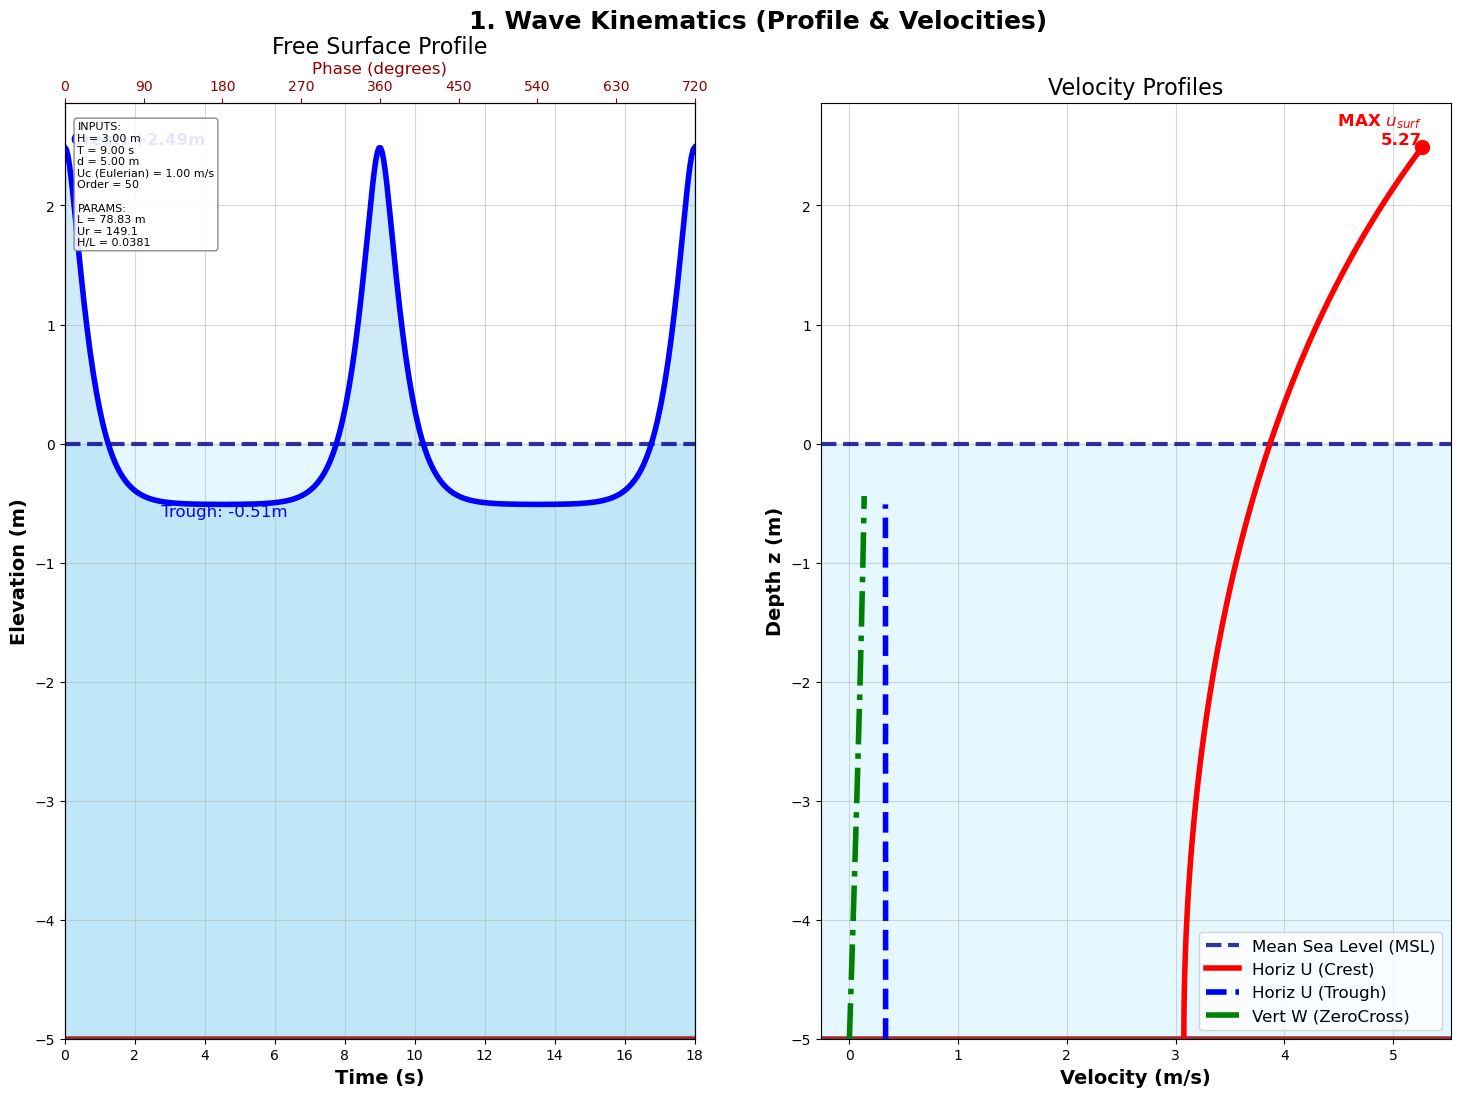

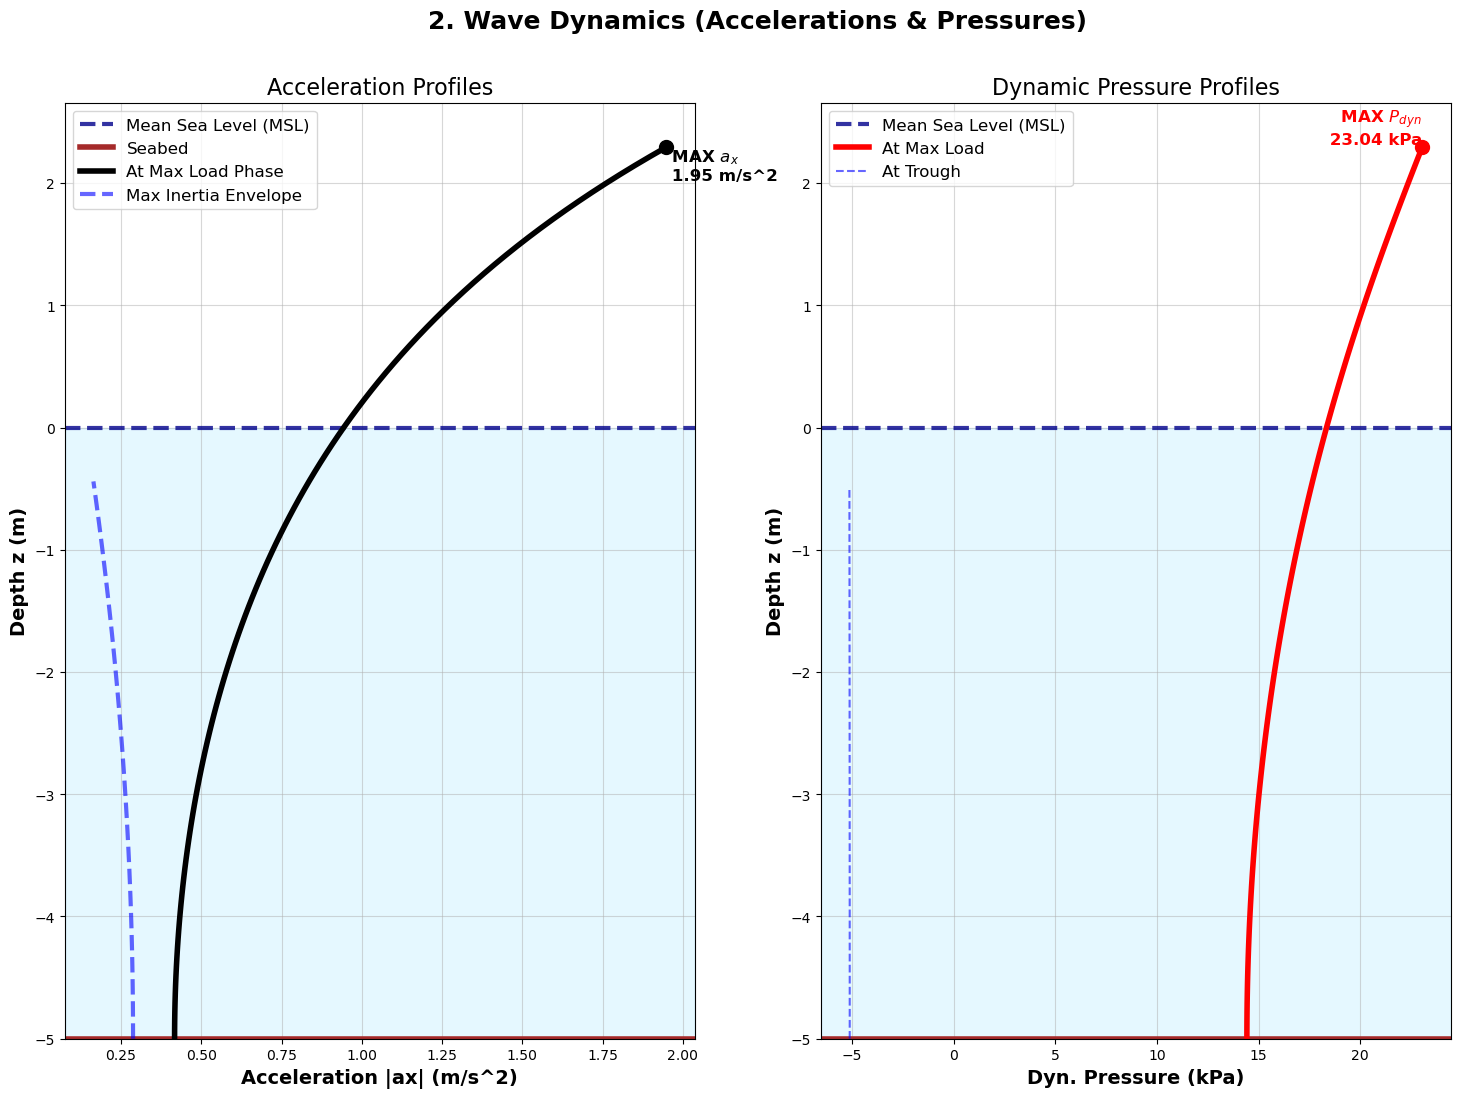

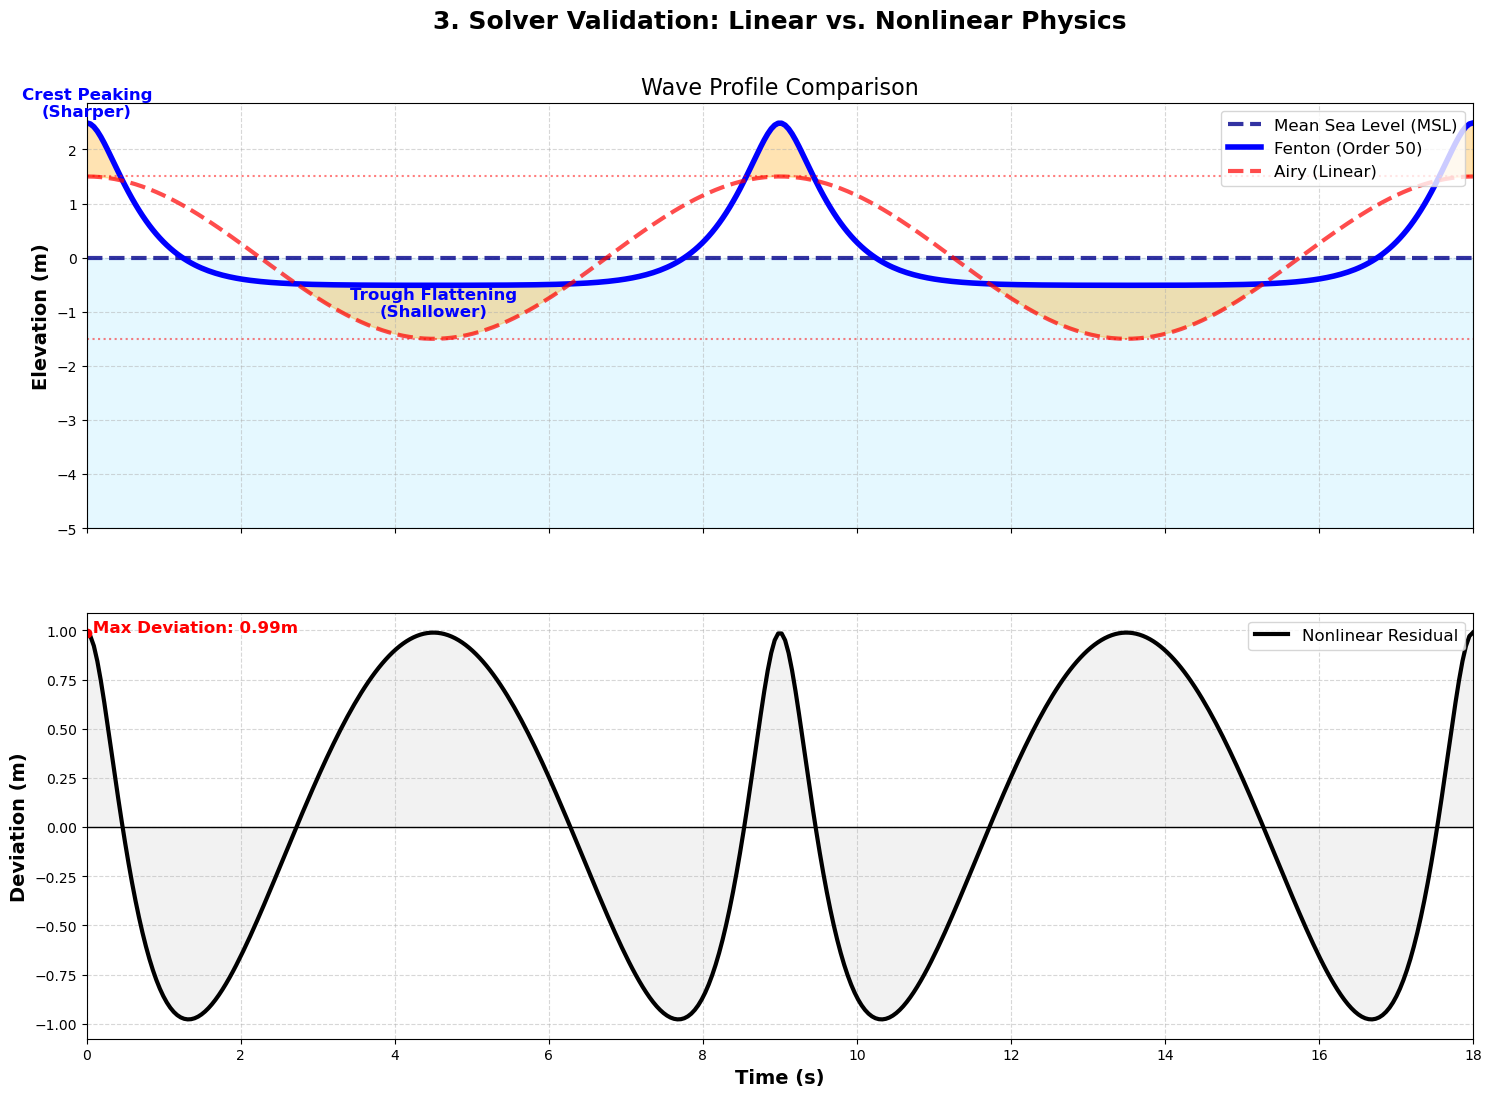

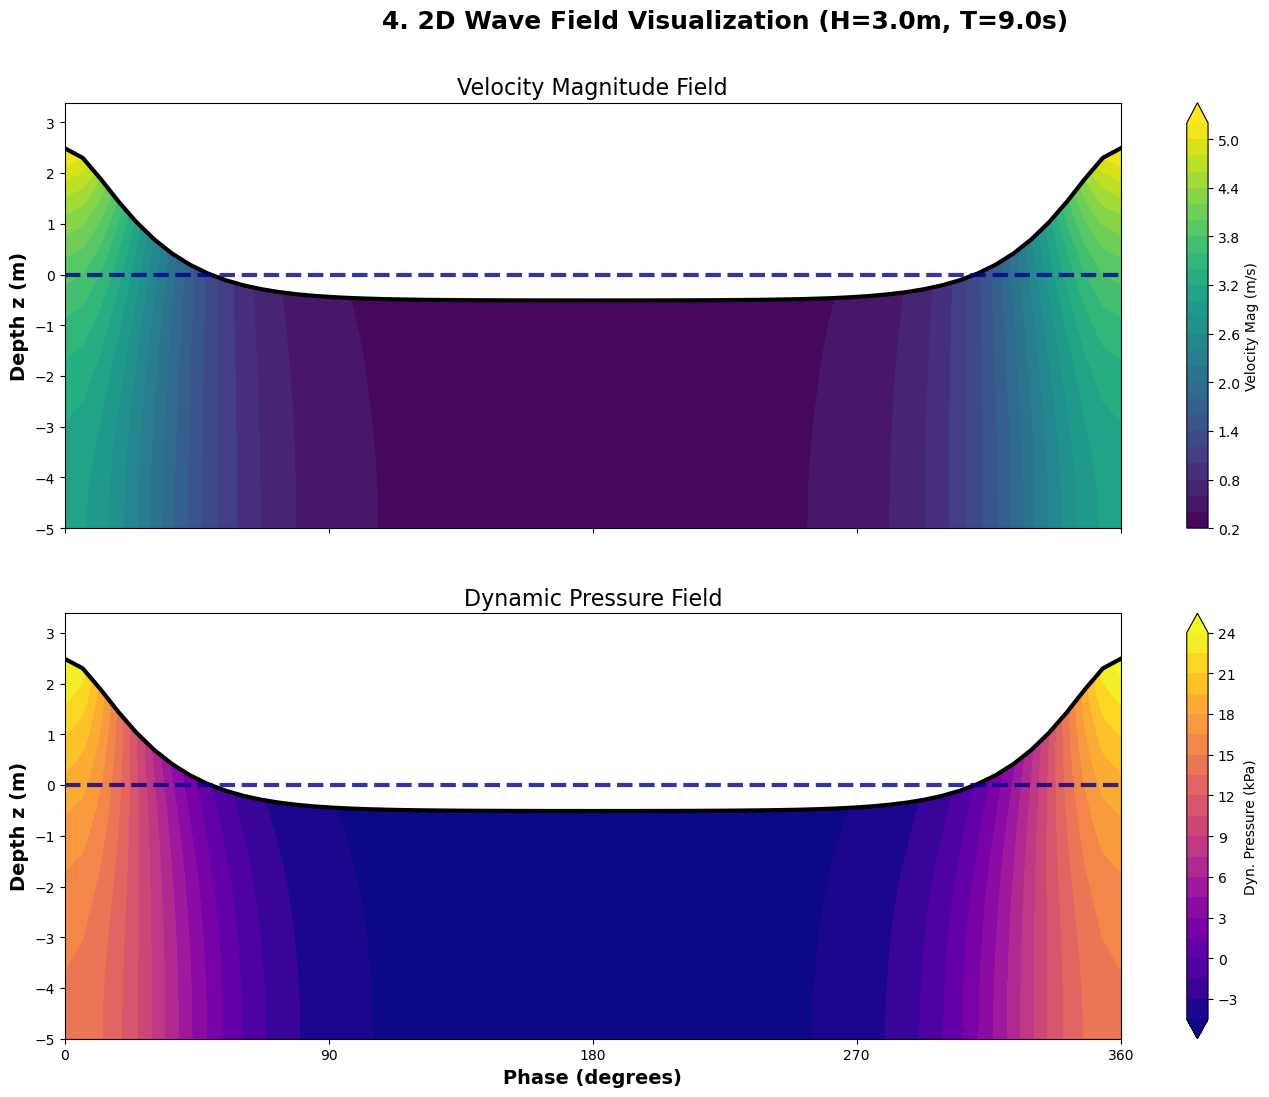

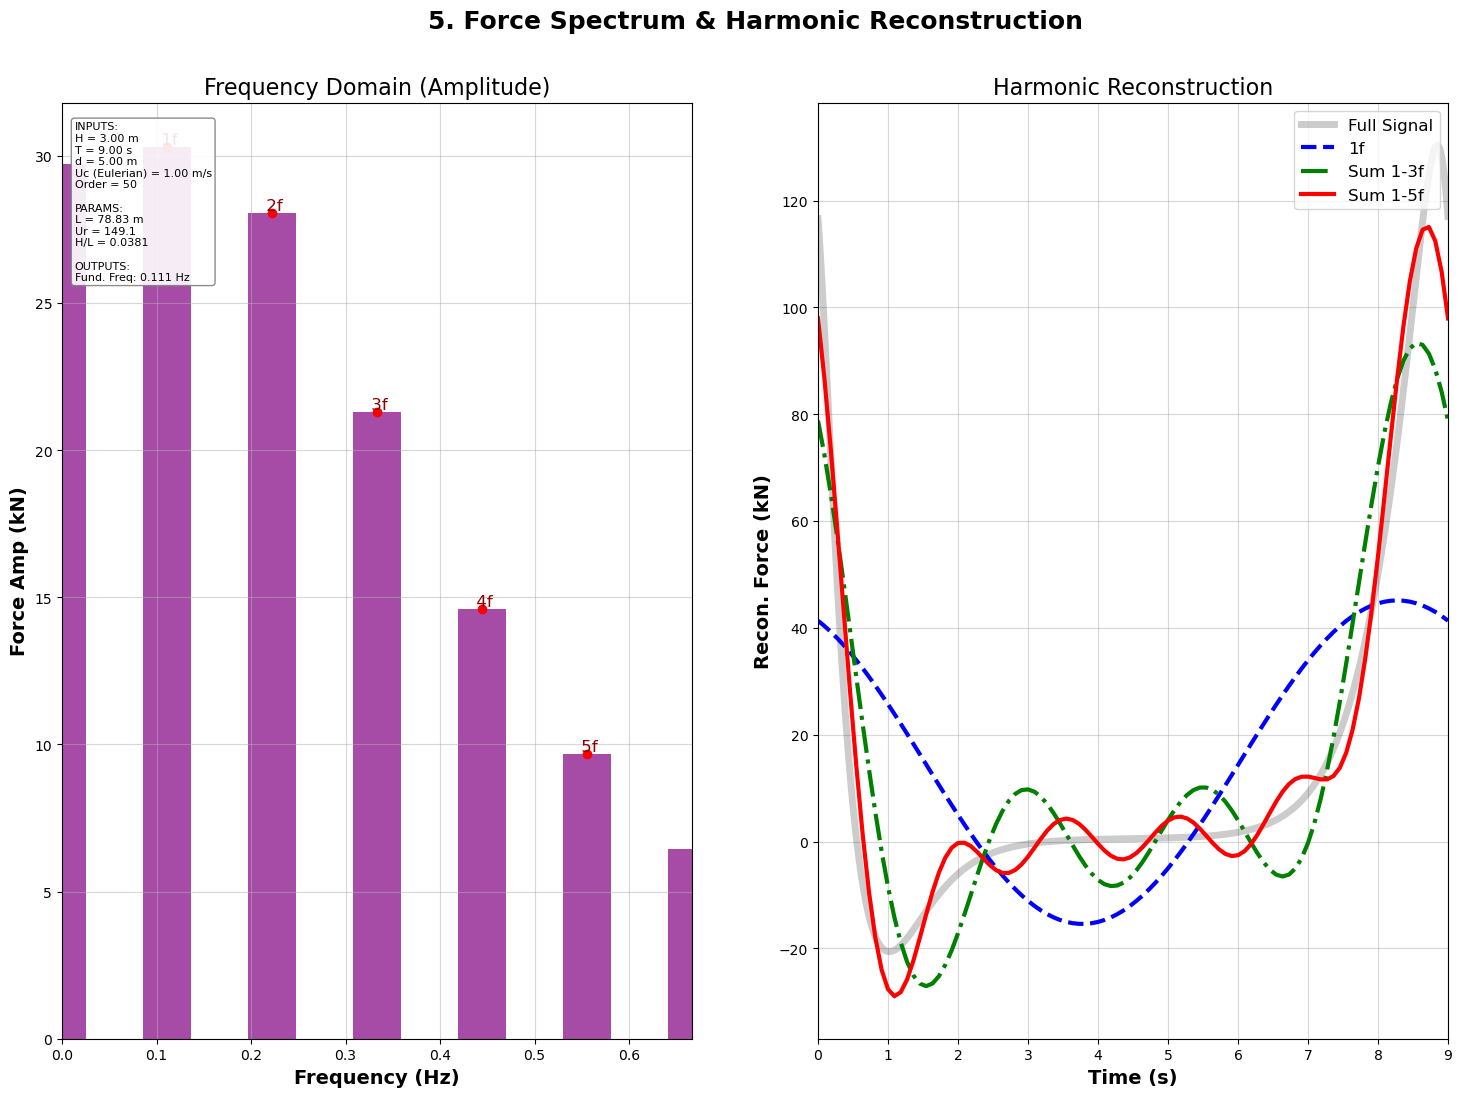

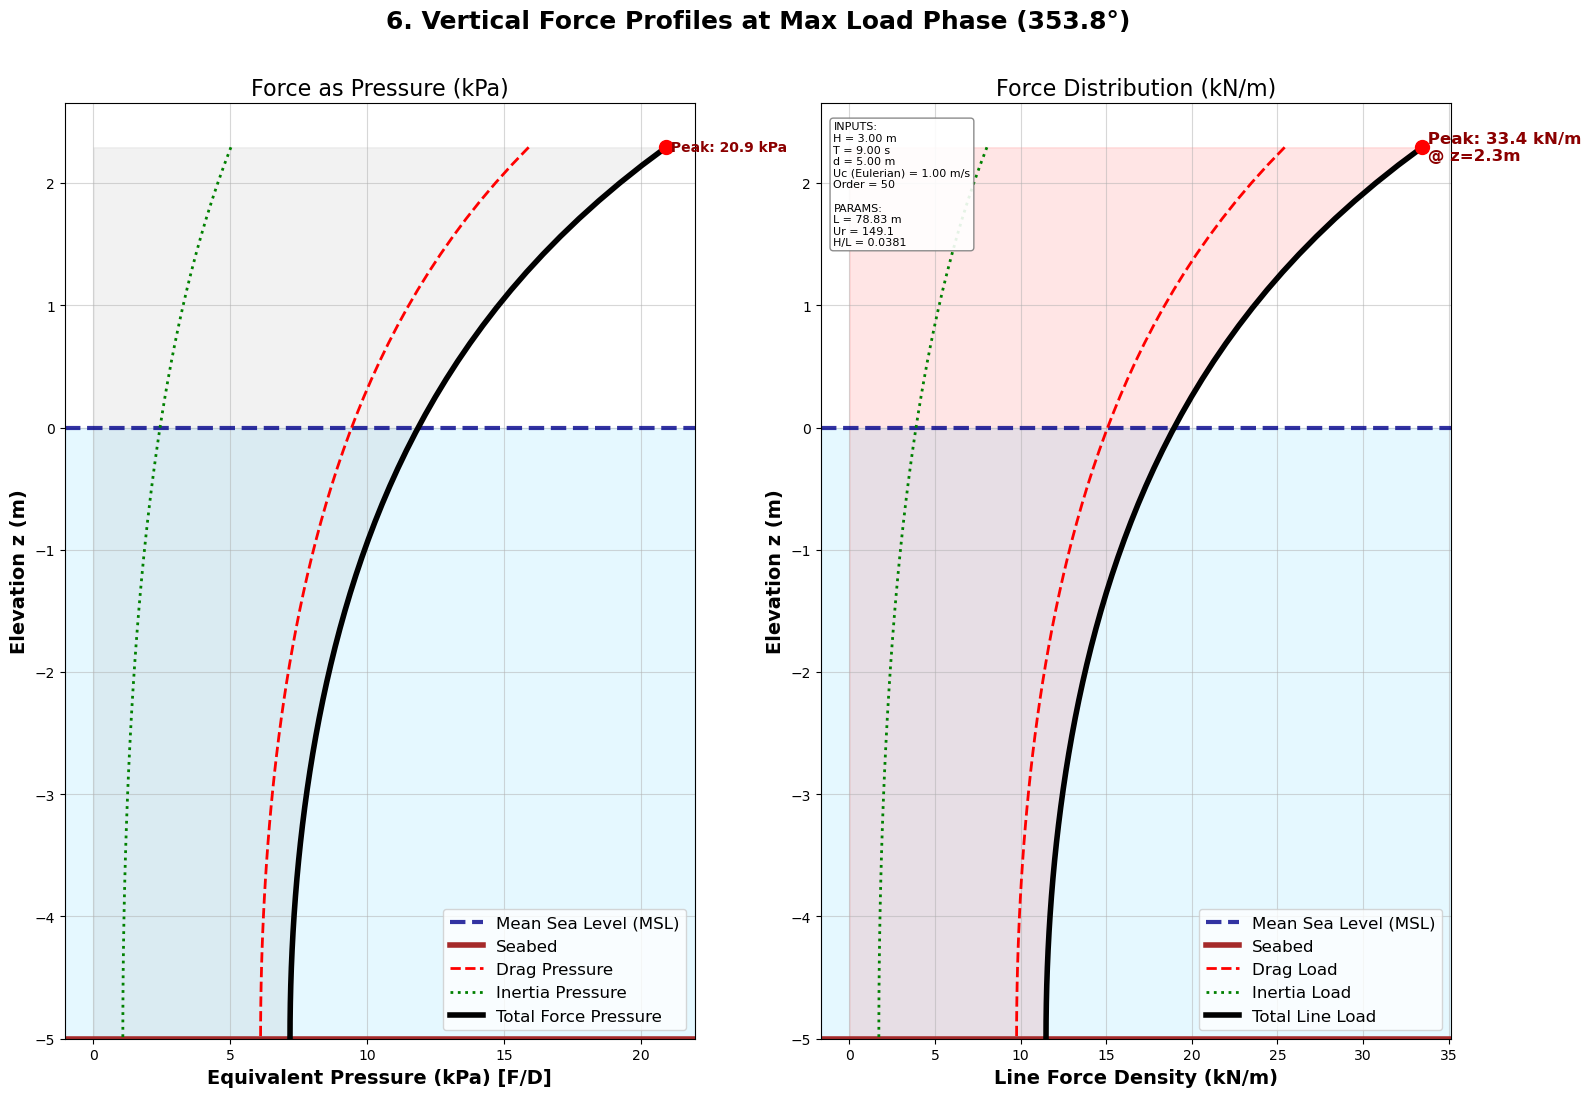

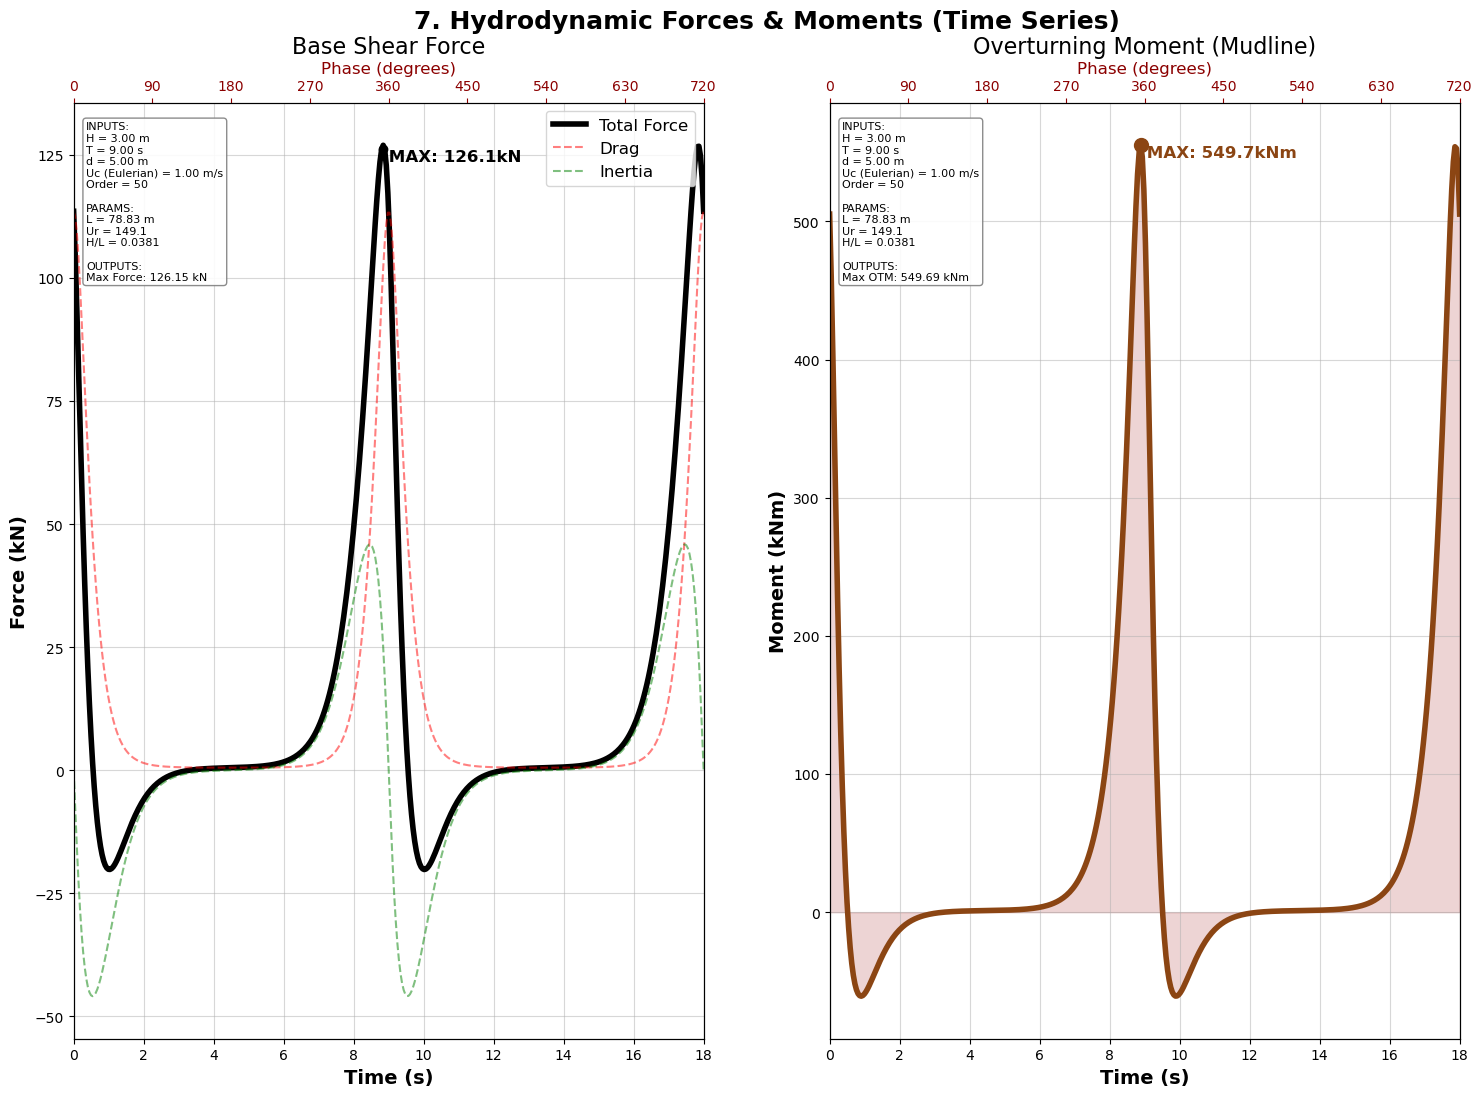

In [6]:
# ==============================================================================
#  SECTION 6: MAIN ENTRY POINT
# ==============================================================================

print("Initializing Fenton Wave Solver...")
print("Parameters: H={:.2f}m, T={:.2f}s, d={:.2f}m, Uc={:.2f}m/s".format(DEF_WAVE_HEIGHT, DEF_WAVE_PERIOD, DEF_DEPTH, DEF_CURRENT))

# 1. Coefficients (BS 6349-1)
CD_CFG = 1.30
CM_CFG = 2.00

# 2. Solver
wave = FentonWave(DEF_WAVE_HEIGHT, DEF_WAVE_PERIOD, DEF_DEPTH, DEF_CURRENT, DEF_CURRENT_TYPE)

# 3. Execution
if wave.converged:
    # Post-Processing
    d_eff = DEF_PILE_DIAMETER + 2*DEF_MARINE_GROWTH
    eta_crest_abs = wave.get_eta_at_x(0) 
    u_c, _, _, _, _ = wave.get_kinematics_at_y(eta_crest_abs, 0) 
    u_orbital = u_c - wave.prop_u1
    kc = u_orbital * DEF_WAVE_PERIOD / d_eff
    re_num = u_c * d_eff / NU_SEAWATER
    
    res = scan_force(wave, DEF_PILE_DIAMETER, DEF_MARINE_GROWTH, CM_CFG, CD_CFG)
    
    # Reports
    generate_report(wave, res, DEF_WAVE_HEIGHT, DEF_DEPTH, DEF_WAVE_PERIOD, 
                   DEF_CURRENT, DEF_CURRENT_TYPE, DEF_PILE_DIAMETER, 
                   DEF_MARINE_GROWTH, d_eff, kc, "BS 6349-1", CD_CFG, CM_CFG, re_num)
                   
    generate_plots(wave, res, DEF_WAVE_HEIGHT, DEF_DEPTH, DEF_WAVE_PERIOD, 
                          DEF_PILE_DIAMETER, DEF_MARINE_GROWTH, CM_CFG, CD_CFG)
else:
    print("Solver Failed.")